Ignore still work in progress

In [1]:
# %pip install rasterio fiona scikit-learn seaborn shapely patchify Pillow

In [2]:
import rasterio as rio
import fiona
import patchify
import numpy as np
import matplotlib.pyplot as plt
import PIL
import pandas as pd
from rasterio.mask import mask
from rasterio.plot import show, adjust_band
from fiona.model import to_dict

In [3]:
REGION_FILE = "Data/s2images/img.tif"

# name of the label 
# 0 is agri
# 1 is water
# 2 is urban
# 3 is barren
AGRI = 0
WATER = 1
URBAN = 2
BARREN = 3
NO_DATA = 4

PATCH_DIM = (11,11)

BOUNDS = [
    {
        "name": "Agri",
        "file": "./Data/boundaries/0_AgriBounds.shp",
        "label": AGRI
    },
    {
        "name": "Water",
        "file": "./Data/boundaries/1_WaterBounds.shp",
        "label": WATER
    },
    {
        "name": "Urban",
        "file": "./Data/boundaries/2_UrbanBounds.shp",
        "label": URBAN
    },
    {
        "name": "Barren",
        "file": "./Data/boundaries/3_BarrenBounds.shp",
        "label": BARREN
    },
    {
        "name": "NoData",
        "label": NO_DATA
    }
]

In [4]:
src = rio.open(REGION_FILE)

blue = src.read(1, masked=True)
green = src.read(2, masked=True)
red = src.read(3, masked=True)
nir = src.read(4, masked=True)
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

# Normalize the bands
redn = normalize(red)
greenn = normalize(green)
bluen = normalize(blue)
nirn = normalize(nir)

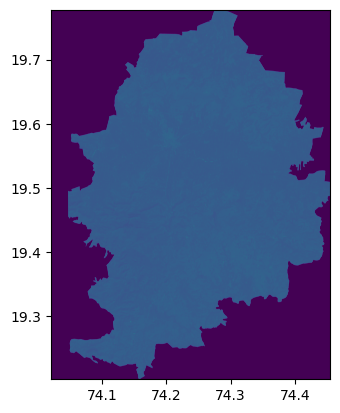

<Axes: >

In [5]:
show(src)

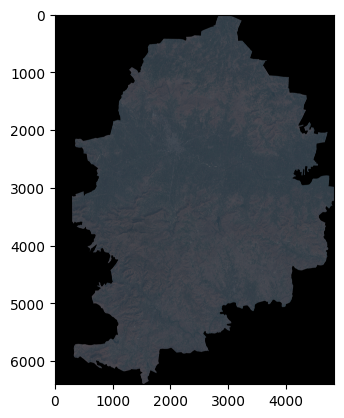

In [6]:
rgb = np.dstack((redn, greenn, bluen))

plt.imshow(rgb)

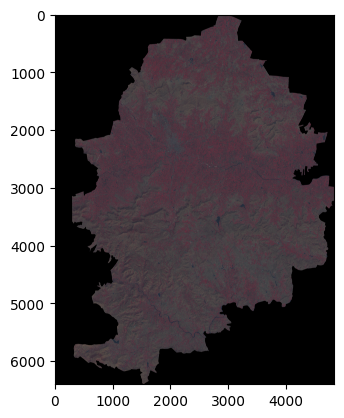

In [7]:
nrg = np.dstack((nirn, redn,greenn))

plt.imshow(nrg)

(4, 11, 12)


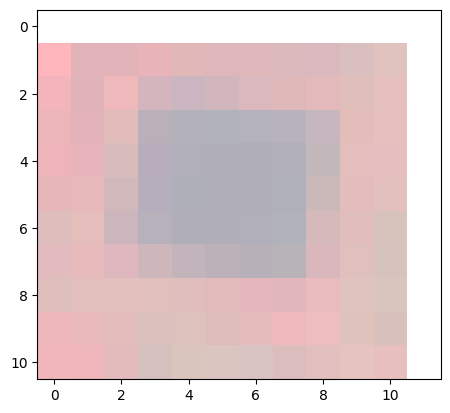

<Axes: >

In [8]:
# Note: There is some missing data hence some shapes have pixel values of 0
# Probably due to some lossy compression while exporting src img

agrShp = fiona.open(BOUNDS[WATER]["file"], crs=src.crs)
first = agrShp[0]['geometry']
crop_img, _ = mask(src, [first], crop=True)
crop_img = adjust_band(crop_img)
print(crop_img.shape)
show(crop_img[::-1])  

In [9]:
def convertPatchesToNumpyImage(shp: fiona.Collection, img):
    # converts shp to image numpy array
    # clips bounds from given img
    # return np array of shape (sample size, 11, 11, 4)
    samples = np.empty((0,11, 11, 4))
    for feature in shp:
        geometry = [feature["geometry"]]
        out_image, _  = mask(img, geometry, crop=True)
        if out_image.shape != (4,11,11):
            out_image = out_image[:,:11,:11]
        # roll axis from (4,11,11) to (11,11,4)
        out_image = np.rollaxis(out_image, 0, 3)
        out_image = np.expand_dims(out_image, axis=0)
        samples = np.concatenate((samples, out_image), axis=0)
    return samples

In [10]:
# Note: There is some missing data hence some shapes have pixel values of 0
# Probably due to some lossy compression while exporting src img

labelArr = np.empty((0,1))
dataset = np.empty((0,11,11,4))
for bound in BOUNDS:
    if bound["label"] == NO_DATA:
        continue
    # index corresponds to label
    shp = fiona.open(bound["file"])
    labelArr = np.concatenate((labelArr, np.full((len(shp), 1), bound["label"])), axis=0)
    # Add logic to augment before adding to dataset
    dataset = np.concatenate((dataset, convertPatchesToNumpyImage(shp, src)), axis=0)

# Adding dummy data for nodata
nodata = np.zeros((100,11,11,4))
dataset = np.concatenate((dataset, nodata), axis=0)
labelArr = np.concatenate((labelArr, np.full((100, 1), 4)), axis=0)

In [11]:
dataset.shape, labelArr.shape

((1098, 11, 11, 4), (1098, 1))

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

tf.keras.backend.clear_session()

X_train, X_test, y_train, y_test = train_test_split(dataset, labelArr, test_size = 0.20)

model = tf.keras.models.Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(11, 11, 4)),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu', input_shape=(11, 11, 4)),
    MaxPooling2D(2,2),
    Flatten(), # flatten out the layers
    Dense(32,activation='relu'),
    Dense(5,activation = 'softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [13]:
model.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test))

Epoch 1/25


28/28 [==============================] - 2s 19ms/step - loss: 120.0565 - accuracy: 0.3964 - val_loss: 6.3617 - val_accuracy: 0.4636
Epoch 2/25
28/28 [==============================] - 0s 6ms/step - loss: 3.9011 - accuracy: 0.6059 - val_loss: 2.8553 - val_accuracy: 0.5909
Epoch 3/25
28/28 [==============================] - 0s 7ms/step - loss: 1.7933 - accuracy: 0.7699 - val_loss: 2.6560 - val_accuracy: 0.7273
Epoch 4/25
28/28 [==============================] - 0s 6ms/step - loss: 1.5819 - accuracy: 0.7688 - val_loss: 1.3213 - val_accuracy: 0.7864
Epoch 5/25
28/28 [==============================] - 0s 7ms/step - loss: 1.1467 - accuracy: 0.8269 - val_loss: 2.2115 - val_accuracy: 0.7364
Epoch 6/25
28/28 [==============================] - 0s 7ms/step - loss: 2.0548 - accuracy: 0.7631 - val_loss: 1.7974 - val_accuracy: 0.8545
Epoch 7/25
28/28 [==============================] - 0s 6ms/step - loss: 1.3611 - accuracy: 0.8189 - val_loss: 0.8249 - val_accuracy: 0.8318
Epoch 8/25
28/2

In [14]:
y_pred = model.predict(X_test)

7/7 [==============================] - 0s 3ms/step


In [15]:
max_y_pred = np.argmax(y_pred, axis=1)
max_y_pred = np.reshape(max_y_pred, (max_y_pred.shape[0], 1))

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97        68
         1.0       1.00      1.00      1.00        36
         2.0       0.96      0.92      0.94        59
         3.0       0.96      0.98      0.97        46
         4.0       1.00      1.00      1.00        11

    accuracy                           0.97       220
   macro avg       0.98      0.98      0.98       220
weighted avg       0.97      0.97      0.97       220

[[67  0  1  0  0]
 [ 0 36  0  0  0]
 [ 3  0 54  2  0]
 [ 0  0  1 45  0]
 [ 0  0  0  0 11]]


Text(48.75, 0.5, 'Actual')

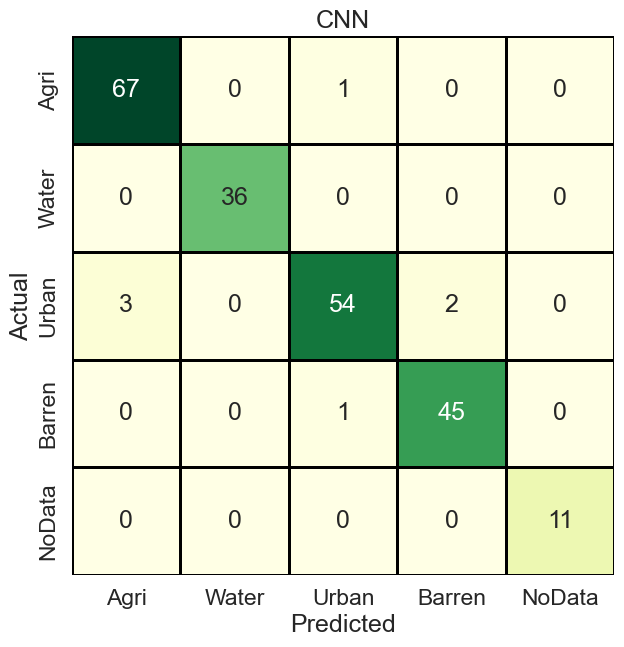

In [16]:
import seaborn as sns
lulc_name = [label["name"] for label in BOUNDS]

print(classification_report(y_test, max_y_pred))
cm = confusion_matrix(y_test, max_y_pred)
print(cm)

# cm_percent = cm/np.sum(cm)

plt.figure(figsize=(7, 7), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)

sns.heatmap(cm,
            xticklabels=lulc_name,
            yticklabels=lulc_name,
            cmap="YlGn",
            annot=True,
            cbar=False,
            linewidths=2,
            linecolor='black')

plt.title("CNN")
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [17]:
print("src shape: ", src.shape)

src shape:  (6405, 4844)


In [18]:
img_np = src.read()
img_np = np.rollaxis(img_np, 0, 3)

# adding blank pixels to make it divisible by 11
# height = 6413
# width = 4851
blank_cols = np.zeros((img_np.shape[0], 7, 4))
img_np = np.hstack((img_np, blank_cols))
blank_rows = np.zeros((8, img_np.shape[1], 4))
img_np = np.vstack((img_np, blank_rows))
print("New Shape: ", img_np.shape)

# Extract Patches
patches = patchify.patchify(img_np, (11,11,4), step=11)
print("Patches Arr Shape: ", patches.shape)
print("583 rows of patches, 441 cols of patches, 11 rows of pixels, 11 cols of pixels, 4 bands")

New Shape:  (6413, 4851, 4)
Patches Arr Shape:  (583, 441, 1, 11, 11, 4)
583 rows of patches, 441 cols of patches, 11 rows of pixels, 11 cols of pixels, 4 bands


In [19]:
# NP arrays for colos

# For Agri
green = np.array(PIL.Image.new("RGB", (11, 11), color="green"))
# For Water
blue = np.array(PIL.Image.new("RGB", (11, 11), color="blue"))
# For Urban
red = np.array(PIL.Image.new("RGB", (11, 11), color="red"))
# For Barren
yellow = np.array(PIL.Image.new("RGB", (11, 11), color="yellow"))
# For NoData
black = np.array(PIL.Image.new("RGB", (11, 11), color="black"))

In [20]:
# Image Segmentation

segmentedImageShape = (patches.shape[0], patches.shape[1], 1, 11, 11, 3)
segmentedImage = np.empty(segmentedImageShape)

for x in range(patches.shape[0]):
    t = patches[x, :, 0, :, :, :]
    pred = model.predict(t)
    print("Current Row: ",x)
    for y in range(patches.shape[1]):
        yth_pixel = np.argmax(pred[y])
        if yth_pixel == 0:
            o = green
        elif yth_pixel == 1:
            o = blue
        elif yth_pixel == 2:
            o = red
        elif yth_pixel == 3:
            o = yellow
        else:
            o = black
        segmentedImage[x,y,0] = o

14/14 [==============================] - 0s 3ms/step
Current Row:  0
14/14 [==============================] - 0s 3ms/step
Current Row:  1
14/14 [==============================] - 0s 2ms/step
Current Row:  2
14/14 [==============================] - 0s 2ms/step
Current Row:  3
14/14 [==============================] - 0s 2ms/step
Current Row:  4
14/14 [==============================] - 0s 2ms/step
Current Row:  5
14/14 [==============================] - 0s 2ms/step
Current Row:  6
14/14 [==============================] - 0s 2ms/step
Current Row:  7
14/14 [==============================] - 0s 3ms/step
Current Row:  8
14/14 [==============================] - 0s 2ms/step
Current Row:  9
14/14 [==============================] - 0s 2ms/step
Current Row:  10
14/14 [==============================] - 0s 3ms/step
Current Row:  11
14/14 [==============================] - 0s 2ms/step
Current Row:  12
14/14 [==============================] - 0s 3ms/step
Current Row:  13
14/14 [=======================

In [21]:
# Unpatching Image
unpatch = patchify.unpatchify(segmentedImage, (img_np.shape[0], img_np.shape[1], 3))

In [22]:
# remove padded pixels
unpatch[:-8,:-7,:].shape

(6405, 4844, 3)

In [23]:
unpatch.shape

(6413, 4851, 3)

In [24]:
tosave = np.rollaxis(unpatch, 2, 0)
tosave.shape

(3, 6413, 4851)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


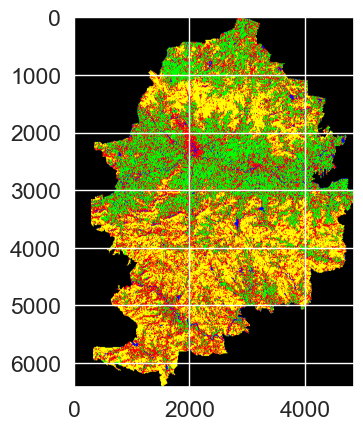

<Axes: >

In [25]:
show(tosave)

In [26]:
with rio.open(
    "./Data/output/segmented.tif", 'w',
    driver=src.driver,
    width=src.shape[1],
    height=src.shape[0],
    count=3,
    crs=src.crs,
    transform=src.transform,
    dtype=unpatch.dtype
) as dst:
    dst.write(tosave[0], 1)
    dst.write(tosave[1], 2)
    dst.write(tosave[2], 3)